In [56]:
from __future__ import print_function
import os
import sys
import numpy as np
import torch
import glob
import pandas as pd
from io import StringIO
from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
import random
import tempfile
import io
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import csv
import uuid
seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)
%matplotlib inline
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

In [79]:
#data = np.load('../train/training_hela.npy')

In [57]:
gcs_enabled = 1
test_dir = 'test'
root = 'inara-debug-10'
model_dir = 'model'
gcs_storage_client = storage.Client()
gcs_bucket = gcs_storage_client.get_bucket(root)

In [58]:
def read_data_from_blob(blob):
        data_string = blob.download_as_string().decode('utf-8')
        return torch.from_numpy(np.loadtxt(StringIO(data_string), delimiter='\t')).float()

def read_data_from_file(file_name):
    npy_file_name = file_name.replace('.csv', '.npy')
    if os.path.exists(npy_file_name):
        data = torch.from_numpy(np.load(npy_file_name)).float()
    else:
        data = torch.from_numpy(np.loadtxt(file_name, delimiter='\t')).float()
    return data


def write_data_to_file(data, file_name):
    stream = io.StringIO()
    writer = csv.writer(stream, delimiter='\t', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for i in range(data.size(0)):
        row = data[i].detach().cpu().numpy()
        writer.writerow(row)
    with open(file_name, 'w') as file:
        file.write(stream.getvalue())

def write_data_to_blob(data, blob):
    stream = io.StringIO()
    writer = csv.writer(stream, delimiter='\t', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for i in range(data.size(0)):
        row = data[i].detach().cpu().numpy()
        writer.writerow(row)
    blob.upload_from_string(stream.getvalue())

def get_latest_model(device, model_dir, gcs_bucket=None, model_filename_prefix=None):
    if model_filename_prefix is None:
        model_filename_prefix = 'inara_'

    if gcs_bucket is not None:
        # Get the latest model from bucket
        model_list = list(gcs_bucket.list_blobs(prefix=os.path.basename(model_dir)))
        # print(model_list)
        model_list = [model for model in model_list if model_filename_prefix in model.name]
        sorted_model_list = sorted(model_list, key=lambda model: os.path.basename(model.name))
        # print(sorted_model_list)
        model_blob = sorted_model_list[-1]
        tmp_file = tempfile.NamedTemporaryFile()
        model_blob.download_to_file(tmp_file)
        # Setting the data pointer in the file
        tmp_file.seek(0)
        # Load the saved model
        model_dict = torch.load(tmp_file,map_location='cpu')
        model_filename = model_blob.name
    else:
        # Same as above just from file system
        model_list = glob.glob(os.path.join(model_dir, model_filename_prefix + '*'))
        if len(model_list) == 0:
            print('No model files found.')
            sys.exit(1)
        else:
            sorted_model_list = sorted(model_list)
            model_filename = sorted_model_list[-1]
            model_dict = torch.load(model_filename,map_location='cpu')
    print('Loaded model:', model_filename)
    return model_dict

In [59]:
def get_model_info(model_dict):
    ret = ['Model type             : {}'.format(model_dict['model_type']),
           'Training epochs        : {:,}'.format(model_dict['epoch']),
           'Training iterations    : {:,}'.format(model_dict['iteration']),
           'Training minibatch size: {:,}'.format(model_dict['minibatch_size']),
           'Seed                   : {}'.format(model_dict['seed']),
           'Initial training loss  : {:.6E}'.format(model_dict['train_loss_history'][0]),
           'Final training loss    : {:.6E}'.format(model_dict['train_loss_history'][-1]),
           'Minimum training loss  : {:.6E}'.format(model_dict['train_loss_min']),
           'Initial validation loss: {:.6E}'.format(model_dict['valid_loss_history'][0]),
           'Final validation loss  : {:.6E}'.format(model_dict['valid_loss_history'][-1]),
           'Minimum validation loss: {:.6E}'.format(model_dict['valid_loss_min'])]
    return '\n'.join(ret)

In [61]:
class FeedForwardNet1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.config_str = ''

    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = self.fc1.forward(x)
        x = F.relu(x)
        x = self.fc2.forward(x)
        x = F.relu(x)
        x = F.dropout(x, 0.2, training = self.training)
        x = self.fc3.forward(x)
        #x = F.dropout(x, 0.2, training = self.training)
        x = F.softmax(x, dim=1)  # this is only for the time-being when we are predicting concentrations, which are all in [0,1] and sum up to 1.
        return x

In [62]:
print('\n*** TEST MODE ***\n')
print('Checking test files in dir : {} ...'.format(test_dir))
if gcs_enabled:
    test_files = list(gcs_bucket.list_blobs(prefix=test_dir))
    test_files = [os.path.basename(file.name) for file in test_files if 'csv' in file.name]
else:
    test_files = glob.glob(os.path.join(root, os.path.join(test_dir, '*.csv')))

# Filtering out any test output files in the subdirectories that may be remaining from a previous test execution. We don't want to treat them as test input files.
test_files = [file for file in test_files if 'output' not in file]

if len(test_files) == 0:
    print('No files found in test_dir: {}'.format(test_dir))
    sys.exit(1)

print('\nFound test files:')
for test_file in test_files:
    print(test_file)

print('\nChecking models in dir : {} ...'.format(model_dir))
if gcs_enabled:
    model_files = list(gcs_bucket.list_blobs(prefix=model_dir))
    model_files = [os.path.basename(file.name) for file in model_files if '.model' in file.name]
else:
    model_files = glob.glob(os.path.join(root, os.path.join(model_dir, '*.model')))

regex = r"inara_seed_(.*)_snapshot"
matches = list(re.finditer(regex, '\n'.join(model_files), re.MULTILINE))
seeds = [match.group(1) for match in matches]
seeds = list(set(seeds))

print('\nFound model files:')
for model_file in model_files:
    print(model_file)

print('\nFound random number seeds:')
for seed in seeds:
    print(seed)


*** TEST MODE ***

Checking test files in dir : test ...

Found test files:
fdl_00027584-8fb8-4d4f-958d-20d6009d5702.csv
fdl_000d6c4b-dba1-464d-8790-9449589ad78f.csv
fdl_000fb6b2-af23-440d-bd49-bd6e4e0618cc.csv
fdl_0035d91e-c57f-4e73-ba5e-ee25f62f23ec.csv
fdl_004f2de5-ddc4-48da-93a0-c575c0f4adfb.csv
fdl_0076f85a-655e-4e7e-9f64-ae3e6d5120f3.csv
fdl_0079f079-7b1c-4d68-8a74-7c383be72fa0.csv
fdl_0079f589-342a-440a-ae77-6b608888dfe6.csv
fdl_00810f58-26e8-45c6-830e-044dc086c8cb.csv
fdl_00d37d13-738d-4bfc-9802-72d9e2937fc6.csv
fdl_0109a479-8ea8-4a19-ae68-d73b7d5ff9c7.csv
fdl_010d818a-4525-4208-8bee-4d88773a68c2.csv
fdl_012c1e1d-b0a8-46ab-810b-4f3bfa238dcf.csv
fdl_0141eb16-a301-42b3-9f29-98203b561826.csv
fdl_0186cae1-afce-46a8-8286-d31be01a1686.csv
fdl_01d383ec-1742-4942-b0a4-7fff40a8358e.csv
fdl_01f1bf69-dd51-4859-8790-08b8d68ccdaf.csv
fdl_021dc028-f800-48ac-9861-d98133dcad44.csv
fdl_025c8124-46c4-4bb2-8162-3253b316b3fe.csv
fdl_02719d04-f525-415c-9236-8a0b0d463da3.csv
fdl_028bcbb9-df85-4cbd-

fdl_40728491-c735-4d89-a676-5747f92051a9.csv
fdl_408be671-871a-4847-b9c7-ca21db8766cf.csv
fdl_4092044c-9f03-4631-b0bf-0c908f9128e8.csv
fdl_40a01c33-32ee-40a8-a001-73f11128b1e5.csv
fdl_41336e08-03a1-4310-81a3-bfd88ecb1266.csv
fdl_41aee799-a285-4a99-823e-ef5ac730b917.csv
fdl_41d488a5-9cc4-4bdc-b4f9-1e1ae48f2d25.csv
fdl_421e7a8f-7974-45af-90b5-4b926f8dbc46.csv
fdl_424566ab-e2ac-479a-b03d-c124ec6f93fc.csv
fdl_424c2925-c8f9-4671-85b2-b62533bce276.csv
fdl_42553e9d-e2cc-4080-9c3f-e577f83a308c.csv
fdl_4288e554-cbea-47de-a6fe-c9431356c28b.csv
fdl_429ff38a-0d51-4aab-af5b-3bb9ac85df0d.csv
fdl_42b9e6f8-eff8-4f36-8786-97c4687df1b0.csv
fdl_42dff9fb-3ffb-4758-9a49-647cee27f7d6.csv
fdl_42f1e505-8136-4413-b8e2-d4324be146f1.csv
fdl_431e1000-ddb7-47d4-933f-20d954bad89b.csv
fdl_4365a5da-d092-4ff7-b379-a084f6ac9bb0.csv
fdl_4391a616-7b8b-4ab4-abbf-d64dcac53344.csv
fdl_43ba5595-4e4b-404e-b845-cb8798999db2.csv
fdl_43c435f6-eae2-4b56-b67b-91b40f9ff20f.csv
fdl_43e6d490-6d4e-4d78-ab11-d5bf9ad13942.csv
fdl_441186

In [81]:
T = 10 # No. dropout samples
observation_dim = 4379 # observation size, no clouds, final decision data size
full_dim = 15346    # total spectrum size, no clouds, final decision data size
# Parameter dimension (the full parameter range)
params_dim = 28 # 27  # 39
# The subset of parameters that the neural network predicts
# Upper limit not included (PyTorch slicing)
#params_slice = [14, 26]  # [13, 25] # [25, 36]
#num_features = 4379
obs_index_s = params_dim+full_dim
obs_index_e = params_dim+full_dim+observation_dim
# noise_ind = params_dim+2*full_dim:params_dim+2*full_dim+observation_dim
#x_data = data.iloc[:,obs_index_s:obs_index_e] # Observations (No noise) 
y_data = data.iloc[:,13:25]
#y_data2 = data.iloc[:,1:3] #temperature + radius of star
#print(np.hstack([y_data, y_data2]).shape)
#y_data = np.hstack([y_data, y_data2])
device = 'cpu'

In [82]:
device = 'cpu'
print('\nIterating through model ensemble with {} seeds'.format(len(seeds)))
for seed in seeds:
    print('\n** Loading latest model snapshot for seed: {} ...'.format(seed))
    model_dict = get_latest_model(device, os.path.join(root, model_dir), gcs_bucket, model_filename_prefix='inara_seed_'+str(seed))
    print('Loaded model info:')
    model_info = get_model_info(model_dict)
    print(model_info)
    model = model_dict['model']
    model.to(device='cpu')
    # Set the model in evaluation mode
    #model.eval() #if dropout on because it will degrade your your results (eval mode)
    test_output = np.zeros((len(test_files),T,4,12))
    test_true = np.zeros((len(test_files),4,12))
    n = 0
    for test_file in test_files:
        print('\nReading test input file: {} ...'.format(test_file))
        if gcs_enabled:
            test_input = read_data_from_blob(gcs_bucket.get_blob(os.path.join(test_dir, test_file)))
        else:
            test_input = read_data_from_file(os.path.join(root, os.path.join(test_dir, test_file)))
        print(test_input.shape)
        test_true[n] =  test_input[:,13:25]
        test_input = test_input[:, params_dim+full_dim:params_dim+full_dim+observation_dim]
        test_input = test_input.to(device='cpu')
        # Run the neural network, get test output
        print('Running model...')
        print('THE SHAPE OF THE TEST_INPUT IS :', test_input.shape)
        test_output[n] = np.array([model.forward(test_input).data.numpy() for _ in range(T)])
        print('THE SHAPE OF THE TEST_OUTPUT IS :', test_output.shape)

        test_output_file_name = test_file.replace('.csv', '') + '_output_seed_{}_execution_{}.csv'.format(seed, uuid.uuid4())
        n+=1
        print('Current file:', n)
        #take mean over dimension T
        #plot prediction mean of pred against true against test (testfile)
       # test_output_filename_full_path = os.path.join(test_dir, os.path.join('predictions', test_output_file_name))
        #print('Saving test output file: {} ...'.format(test_output_filename_full_path))
        #if gcs_enabled:
        #    blob = gcs_bucket.blob(test_output_filename_full_path)
        #    write_data_to_blob(test_output, blob)
        #else:
        #    write_data_to_file(test_output, test_output_filename_full_path)



Iterating through model ensemble with 2 seeds

** Loading latest model snapshot for seed: 11 ...


/Users/kenobi/anaconda/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type FeedForwardNet1. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Loaded model: model/inara_seed_11_snapshot_1533808948.model
Loaded model info:
Model type             : FF
Training epochs        : 5
Training iterations    : 2,048
Training minibatch size: 256
Seed                   : 11
Initial training loss  : 8.870743E-05
Final training loss    : 2.854795E-05
Minimum training loss  : 2.287762E-05
Initial validation loss: 8.510132E-05
Final validation loss  : 2.626616E-05
Minimum validation loss: 2.594366E-05

Reading test input file: fdl_00027584-8fb8-4d4f-958d-20d6009d5702.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 1

Reading test input file: fdl_000d6c4b-dba1-464d-8790-9449589ad78f.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 2

Reading test input file: fdl_000fb6b2-af23-440d-bd49-bd6e4e0618cc.csv ...

torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 34

Reading test input file: fdl_04e89914-cc84-4171-9a1e-3261e3614a65.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 35

Reading test input file: fdl_05241845-dfbe-49f2-bf2f-76902250653e.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 36

Reading test input file: fdl_055de591-8b2e-4397-9e0e-1e69fd5453bc.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 37

Reading test input file: fdl_0561442b-f478-42e8-8832-bed0ea8539b1.csv ...
torch.Size([4, 76758])
Running model...
THE 

torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 69

Reading test input file: fdl_084969fb-44e4-4cf8-a3c8-659f92550edd.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 70

Reading test input file: fdl_0860613f-d433-48c4-b175-46e286842736.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 71

Reading test input file: fdl_087790b7-4fb2-4f9e-ab91-68db1976247a.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 72

Reading test input file: fdl_0890a928-ff27-4d2b-88cf-77384aae0d9a.csv ...
torch.Size([4, 76758])
Running model...
THE 

torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 104

Reading test input file: fdl_0d080e51-0833-492b-a7b6-d224090d99dc.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 105

Reading test input file: fdl_0d2ff3c9-22a5-4a04-93a2-2ca06106c2fb.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 106

Reading test input file: fdl_0d3c87b8-e1b9-4958-b295-3cb4accf86a3.csv ...
torch.Size([4, 76758])
Running model...
THE SHAPE OF THE TEST_INPUT IS : torch.Size([4, 4379])
THE SHAPE OF THE TEST_OUTPUT IS : (1972, 10, 4, 12)
Current file: 107

Reading test input file: fdl_0d8ccf7e-26c1-42f6-b6df-7bb0744ea61a.csv ...
torch.Size([4, 76758])
Running model...


KeyboardInterrupt: 

In [83]:
#%debug

In [84]:
n

125

In [85]:
test_output.shape

(1972, 10, 4, 12)

In [86]:
mean_output = test_output[:n].mean(1)
true_output = test_true[:n]

In [87]:
mean_output = mean_output.reshape((-1,12))
true_output = true_output.reshape((-1,12))

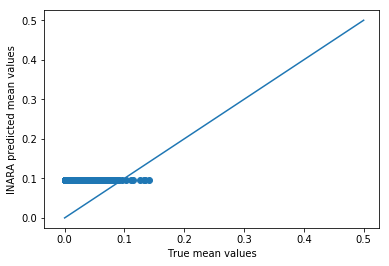

In [88]:
x = [0,.5]
for m in range(2):
    plt.scatter(true_output[:,m],mean_output[:,m])
    plt.xlabel('True mean values')
    plt.ylabel('INARA predicted mean values')
    plt.plot(x,x)
    plt.show()


In [89]:
mean_output

array([[0.08118334, 0.09520536, 0.09481082, ..., 0.0788839 , 0.07868634,
        0.07867784],
       [0.08115453, 0.0953908 , 0.09497124, ..., 0.07882125, 0.07862136,
        0.07861212],
       [0.08112702, 0.09554034, 0.0951347 , ..., 0.07876074, 0.07855785,
        0.07854875],
       ...,
       [0.08114322, 0.0954447 , 0.09504199, ..., 0.0787962 , 0.07859516,
        0.07858581],
       [0.081185  , 0.0952074 , 0.09480141, ..., 0.07888679, 0.07868997,
        0.07868107],
       [0.08112588, 0.09553976, 0.09512878, ..., 0.07876304, 0.07856023,
        0.07855112]])

In [90]:
true_output

array([[2.78022156e+02, 5.94897829e-02, 1.74625635e-01, ...,
        8.92311148e-03, 2.51439400e-03, 1.81679978e-04],
       [2.71968475e+02, 3.94575223e-02, 7.87516758e-02, ...,
        1.16943922e-02, 1.34522375e-03, 6.07549773e-05],
       [2.06967377e+02, 3.67042460e-02, 3.50916326e-01, ...,
        3.43572162e-03, 1.92987884e-03, 2.50978860e-06],
       ...,
       [2.79843567e+02, 6.58536553e-02, 4.84600186e-01, ...,
        1.26744481e-02, 2.38926918e-03, 4.52393397e-05],
       [2.07323257e+02, 6.49558008e-03, 3.49440366e-01, ...,
        1.08349475e-03, 9.60073885e-05, 1.78437869e-04],
       [3.41224731e+02, 5.88446595e-02, 1.33089483e-01, ...,
        4.60588932e-03, 1.52292167e-04, 1.38578855e-06]])

In [91]:
test_true[:n].max()

497.9093322753906